In [86]:
import sentencepiece as spm

import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch
import re
from torchviz import make_dot
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [87]:
# 用您的文本文件路径替换以下路径
input_file = "data/数据.txt"
model_prefix = "bpe_model"
vocab_size = 8000
embedding_dim = 256
top_k = 3
max_sentence_length = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# 训练sentencepiece模型

#spm.SentencePieceTrainer.Train(input='data/数据.txt', model_prefix='m', model_type="bpe", vocab_size=5000)

Using device: cuda


In [88]:


# 加载训练好的模型
sp = spm.SentencePieceProcessor()
sp.load("work1.model")

# 输入句子
sentence = "今天天气真好"

# 将句子处理为token id
token_ids = sp.encode_as_ids(sentence)
print(sp.decode_pieces(sp.encode_as_pieces(sentence)))
# 将token id列表转换为张量
token_ids_tensor = torch.tensor(token_ids)
print(token_ids_tensor)

今天天气真好
tensor([ 572, 5312, 5670, 5713, 5280])


In [89]:


# 数据准备
# data = torch.tensor([ 572, 5312, 5670, 5713, 5280], dtype=torch.float32)
# data = token_ids_tensor
# labels = data.clone()


mask = torch.tensor([1, 0, 0, 0, 0], dtype=torch.long).to(device)

#按概率选择位置
def choose_index_based_on_probability(probabilities):
    chosen_index = torch.multinomial(probabilities, 1)[0]
    return chosen_index

#填充向量
def list_to_fixed_length_tensor(input_list, max_length):
    # 将输入列表转换为张量
    input_tensor = torch.tensor(input_list, dtype=torch.long)
    
    # 如果输入张量的长度小于 max_length，用 0 填充
    if input_tensor.size(0) < max_length:
        padding = torch.zeros(max_length - input_tensor.size(0), dtype=torch.long)
        fixed_length_tensor = torch.cat((input_tensor, padding))
    # 如果输入张量的长度大于 max_length，进行截断
    else:
        fixed_length_tensor = input_tensor[:max_length]
    
    return fixed_length_tensor

#画图
def plot_loss_curve(loss_list):
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.show()
    
#取top_k个最大值
def top_k_elements(tensor, k):
    # 对tensor进行排序，返回排序后的值和索引
    sorted_tensor, sorted_indices = torch.sort(tensor, descending=True)

    # 选择前k大的元素及其在原始tensor中的索引
    top_k_values = sorted_tensor[:k]
    top_k_indices = sorted_indices[:k]

    return top_k_values, top_k_indices

# 多项式分类器模型定义
class MultinomialClassifier(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(MultinomialClassifier, self).__init__()

        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)

        self.linear_probs = nn.Linear(input_dim*embedding_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.embedding_layer(x)
        x = x.view(1,-1)
        x = x[0]
        x = self.linear_probs(x)
        #print(x)
        predicted_probs = torch.softmax(self.relu(x), dim=0)

        result_values, result_indices = top_k_elements(predicted_probs, top_k)
        #print(f"这是原本的概率:{predicted_probs}")
        #print(f"这是tok的位置:{result_indices}")
        #print(f"这是tok的概率:{result_values}"+'\n')
        return result_indices, result_values



# 自定义损失函数
def mean_absolute_error(tensor1, tensor2):
    if tensor1.size() != tensor2.size():
        raise ValueError("Both tensors should have the same size.")

    # 计算两个张量之间的绝对误差
    absolute_errors = torch.abs(tensor1 - tensor2)

    # 计算平均绝对误差
    mae = torch.mean(absolute_errors)
    return mae



In [90]:
def train(model, data_path, optimizer, num_epochs = 100, input_dim = 5, output_dim = vocab_size):
    
    loss_list = []
    min_loss = 160000
    all_line = 0
    now_line = 0
    #optimizer = optim.SGD(model.parameters(), lr=0.001)
    with open(data_path,'r',encoding='utf-8') as f:
        lines = f.readlines()
        f.close()
    all_line = len(lines)
    for line in lines:
        #print(line)
        now_line += 1
        if not line:
            continue
        
        # 将句子处理为token id
        token_ids = sp.encode_as_ids(line)
        

        #将token id列表转换为张量
        token_ids_tensor = list_to_fixed_length_tensor(token_ids,max_sentence_length)
        for i in range(max_sentence_length - input_dim):
            data = token_ids_tensor[i:i+input_dim].to(device)
            labels = data.clone().to(device)
            result = []
            # 训练模型,每一句话训练num_epochs次
            # num_epochs = 100
            for epoch in range(num_epochs):

                result = []
                result.append(data[0].item())
                mask = torch.tensor([1, 0, 0, 0, 0], dtype=torch.long).to(device)
                for i in range(0, input_dim):
                    mask[i] = 1
                    updated_data = torch.mul(data,mask).to(device)
                    
                    x = updated_data
                    
                    predicted_values, predicted_probs = model(x)
                    
                
                    choose_index = choose_index_based_on_probability(predicted_probs)
                    choose_values = predicted_values[choose_index]
                    
                    if i == input_dim-1:
                        break
                    result.append(choose_values.item())
                    
                
                result = torch.tensor(result, dtype=torch.float32, requires_grad=True).to(device)
                

                loss = mean_absolute_error(result, labels)
                if loss < min_loss:
                    min_loss = loss
                    if not os.path.exists("model"):
                        os.makedirs("model")
                    current_time = datetime.now()
                    file_name = current_time.strftime("model_%d_%M.pth")

                    # 保存模型到 "model" 目录下，并使用格式化的文件名
                    torch.save(model.state_dict(), os.path.join("model", file_name))

                loss_list.append(loss.cpu().detach().numpy())
                # 反向传播和优化
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                #if (epoch+1) % 100 == 0:
                if now_line % 20 == 0:
                    print(f'Line [{now_line}/{all_line}], Loss: {loss.item():.4f}')
                #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return loss_list
    

In [91]:
# 模型、损失函数和优化器初始化
input_dim = 5

output_dim = vocab_size  # 输出vocab_size个预测值,最后选择top_k个较大的值
model = MultinomialClassifier(input_dim, output_dim)
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001)
loss_list = train(model=model, data_path = 'data/数据.txt', optimizer=optimizer,num_epochs = 1, input_dim = 5, output_dim = vocab_size)




Line [20/14326], Loss: 2932.2000
Line [20/14326], Loss: 2366.8000
Line [20/14326], Loss: 1805.8000
Line [20/14326], Loss: 3058.2000
Line [20/14326], Loss: 1068.0000
Line [20/14326], Loss: 1083.2001
Line [20/14326], Loss: 2791.6001
Line [20/14326], Loss: 1902.2001
Line [20/14326], Loss: 4282.3999
Line [20/14326], Loss: 3428.6001
Line [20/14326], Loss: 4461.6001
Line [20/14326], Loss: 3518.2000
Line [20/14326], Loss: 3428.6001
Line [20/14326], Loss: 3607.8000
Line [20/14326], Loss: 2754.0000
Line [40/14326], Loss: 2985.4001
Line [40/14326], Loss: 1838.8000
Line [40/14326], Loss: 3104.2000
Line [40/14326], Loss: 2761.2000
Line [40/14326], Loss: 1756.4000
Line [40/14326], Loss: 1281.8000
Line [40/14326], Loss: 2180.4001
Line [40/14326], Loss: 1989.8000
Line [40/14326], Loss: 4282.3999
Line [40/14326], Loss: 3607.8000
Line [40/14326], Loss: 3607.8000
Line [40/14326], Loss: 4461.6001
Line [40/14326], Loss: 3518.2000
Line [40/14326], Loss: 4372.0000
Line [40/14326], Loss: 3518.2000
Line [60/1

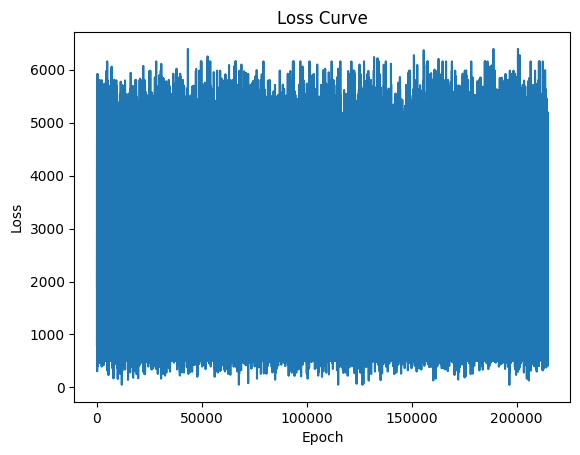

In [77]:
plot_loss_curve(loss_list)

In [78]:
# 要加载的模型文件路径
model_file_path = "model/model_27_33.pth"

# 加载模型状态字典
model_state_dict = torch.load(model_file_path)

# 将状态字典加载到模型中
model.load_state_dict(model_state_dict)

# 将模型设置为评估模式（如果模型包含批量归一化或丢弃层，这是必要的）
model.eval()

MultinomialClassifier(
  (embedding_layer): Embedding(8000, 256)
  (linear_probs): Linear(in_features=1280, out_features=8000, bias=True)
)

In [82]:
# 测试模型
with torch.no_grad():
    test_data = torch.tensor([572, 5312, 5670, 5713, 5280], dtype=torch.long).to(device)
    mask = torch.tensor([1, 0, 0, 0, 0], dtype=torch.long).to(device)
    #updated_test_data = test_data.clone().to(device)

    result = []
    result.append(int(test_data[0].item()))
    for i in range(0, input_dim):

        mask[i] = 1
        updated_test_data = torch.mul(test_data,mask).to(device)
        if i == input_dim-1:
                break
        x = updated_test_data.to(device)
        predicted_values, predicted_probs = model(x)
        choose_index = choose_index_based_on_probability(predicted_probs)
        choose_values = predicted_values[choose_index]
    
        
        print(f'Predicted values: {predicted_values}')
        print(f'Predicted probabilities: {predicted_probs}')
        print(f'选择的位置: {choose_index}'+'\n')
        print(f'选择的值: {choose_values}'+'\n')

        # 依据概率随机选择输出
       
        result.append(choose_values.item())
    print(f'Chosen values: {result}')

Predicted values: tensor([4527, 1478, 5208], device='cuda:0')
Predicted probabilities: tensor([0.0010, 0.0008, 0.0007], device='cuda:0')
选择的位置: 2

选择的值: 5208

Predicted values: tensor([6617, 1478, 2690], device='cuda:0')
Predicted probabilities: tensor([0.0008, 0.0008, 0.0007], device='cuda:0')
选择的位置: 0

选择的值: 6617

Predicted values: tensor([ 722, 2690,  390], device='cuda:0')
Predicted probabilities: tensor([0.0008, 0.0008, 0.0008], device='cuda:0')
选择的位置: 2

选择的值: 390

Predicted values: tensor([ 390, 6612,  722], device='cuda:0')
Predicted probabilities: tensor([0.0010, 0.0008, 0.0008], device='cuda:0')
选择的位置: 1

选择的值: 6612

Chosen values: [572, 5208, 6617, 390, 6612]


In [83]:
# 将ID列表还原为句子
decoded_sentence = sp.decode_ids(result)

print("Decoded sentence:", decoded_sentence)

Decoded sentence: 今天分末 娱扭
